In [1]:
import time
import pickle
import numpy as np 
import torch
from torch import nn
import data_loader
import model
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class StatsManager:
    
    def __init__(self):
        self.init()
        
    def init(self):
        self.running_loss = 0
        self.num_update = 0
        
    def accumulate(self, loss):
        self.running_loss += loss
        self.num_update += 1
        
    def summarize(self):
        #print('loss: {}'.format(self.running_loss / self.num_update))
        return self.running_loss / self.num_update

In [3]:
#load data
try:
    with open('loader.pkl', 'rb') as f:
        train_loader, val_loader = pickle.load(f)
except:
    train_loader, val_loader = data_loader.get_loader(['./data/path%d.txt' % i for i in range(1, 11)])
    with open('loader.pkl', 'wb') as f:
        pickle.dump((train_loader, val_loader), f)
        
print('Data loading complete')

Data loading complete


In [4]:
#hyperparam
lr = 1e-5
num_epoch = 300
lamb = 1e-3

try:
    with open('checkpoint.pkl', 'rb') as f:
        epoch, train_loss, test_loss, optim_state = pickle.load(f)
    enet = torch.load('saved_enet.pth')
    pnet = torch.load('saved_pnet.pth')
    optimizer = torch.optim.Adam(list(enet.parameters())+list(pnet.parameters()), lr = lr, weight_decay = lamb)
    optimizer.load_state_dict(optim_state)
except:
    epoch = 0
    train_loss = []
    test_loss = []
    enet = model.Enet()
    pnet = model.Pnet()
    optimizer = torch.optim.Adam(list(enet.parameters())+list(pnet.parameters()), lr = lr, weight_decay = lamb)
    
if torch.cuda.is_available():
    enet = enet.cuda()
    pnet = pnet.cuda()
enet.train()
pnet.train()

stats = StatsManager()

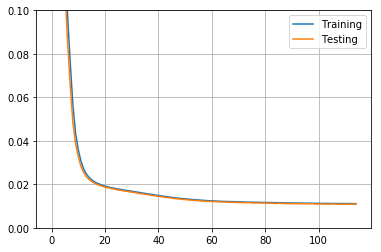

Epoch 115: training loss: 0.011115014553070068, testing loss:0.010862812399864197
Time: 649.014155626297s


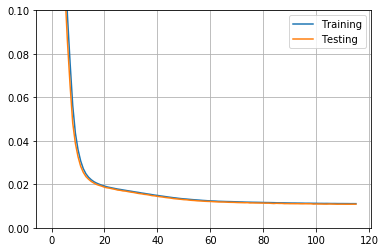

Epoch 116: training loss: 0.011106355115771294, testing loss:0.010858246125280857
Time: 642.2244429588318s


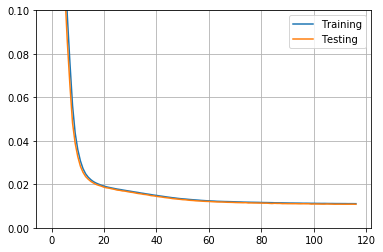

Epoch 117: training loss: 0.011093605309724808, testing loss:0.010822110809385777
Time: 642.815310716629s


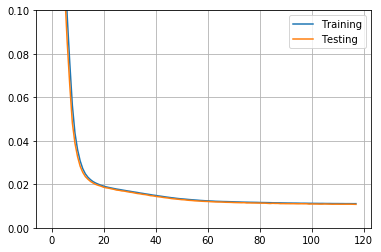

Epoch 118: training loss: 0.011106432415544987, testing loss:0.010791737586259842
Time: 645.770446062088s


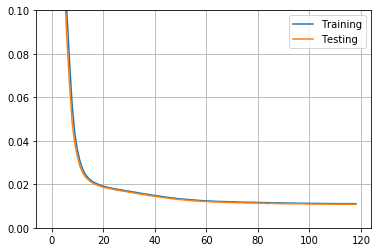

Epoch 119: training loss: 0.011102497577667236, testing loss:0.01083669625222683
Time: 647.2511184215546s


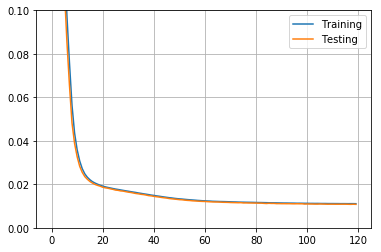

Epoch 120: training loss: 0.011082887649536133, testing loss:0.010789331048727036
Time: 640.0058591365814s


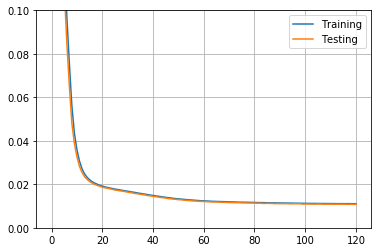

Epoch 121: training loss: 0.011062560603022575, testing loss:0.010799976997077465
Time: 638.680596113205s


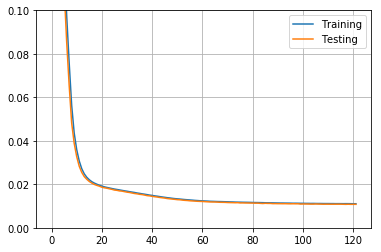

Epoch 122: training loss: 0.011064824648201466, testing loss:0.010794066824018955
Time: 637.0052757263184s


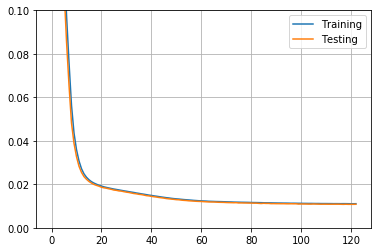

Epoch 123: training loss: 0.011083920486271381, testing loss:0.01082066260278225
Time: 636.2961645126343s


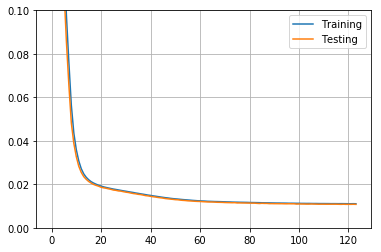

Epoch 124: training loss: 0.011059039272367954, testing loss:0.010785000398755074
Time: 637.4500255584717s


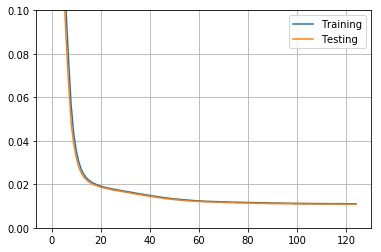

Epoch 125: training loss: 0.011059843003749847, testing loss:0.010773932561278343
Time: 635.6755237579346s


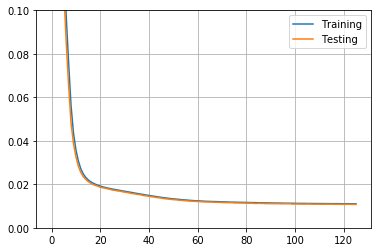

Epoch 126: training loss: 0.011051048524677753, testing loss:0.010735239833593369
Time: 636.1258745193481s


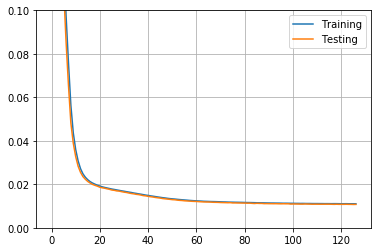

Epoch 127: training loss: 0.011041992343962193, testing loss:0.01076705101877451
Time: 636.8084123134613s


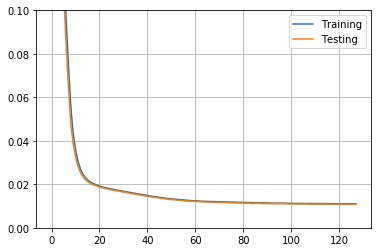

Epoch 128: training loss: 0.011039680801331997, testing loss:0.010770960710942745
Time: 638.4107818603516s


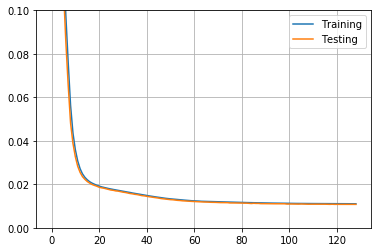

Epoch 129: training loss: 0.011045793071389198, testing loss:0.010775238275527954
Time: 637.5213420391083s


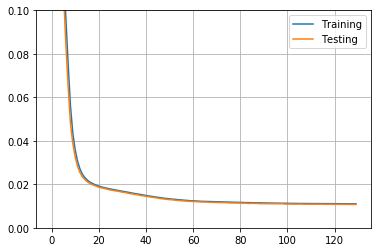

Epoch 130: training loss: 0.011032630689442158, testing loss:0.01072409562766552
Time: 635.9739906787872s


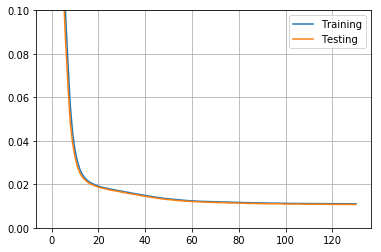

Epoch 131: training loss: 0.011036534793674946, testing loss:0.010725456289947033
Time: 635.6343595981598s


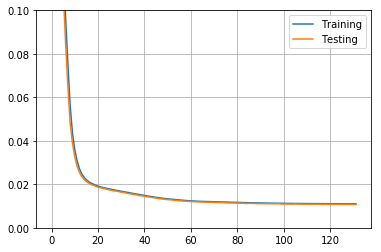

Epoch 132: training loss: 0.011025633662939072, testing loss:0.010742273181676865
Time: 636.619437456131s


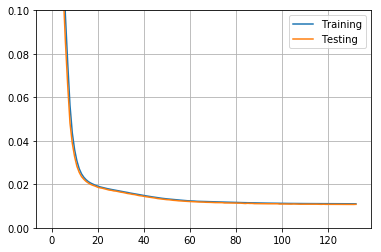

Epoch 133: training loss: 0.011038207449018955, testing loss:0.01079365611076355
Time: 636.0605866909027s


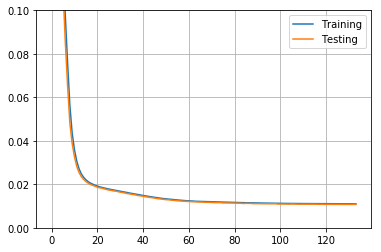

Epoch 134: training loss: 0.011021751910448074, testing loss:0.010741700418293476
Time: 634.4636538028717s


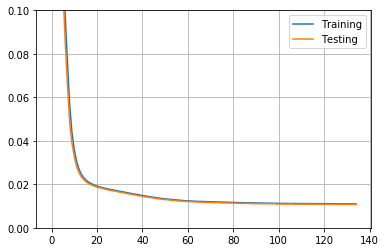

Epoch 135: training loss: 0.011016803793609142, testing loss:0.010731266811490059
Time: 636.8542931079865s


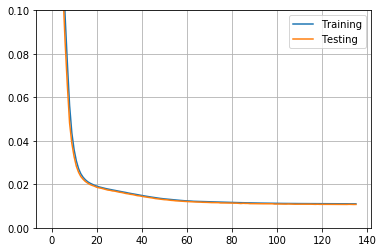

Epoch 136: training loss: 0.011018800549209118, testing loss:0.010750803165137768
Time: 636.4950127601624s


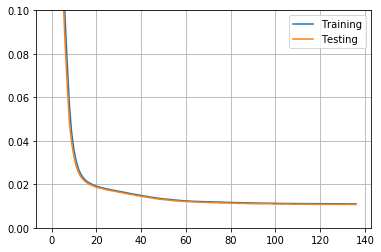

Epoch 137: training loss: 0.011002300307154655, testing loss:0.010729420930147171
Time: 636.0554158687592s


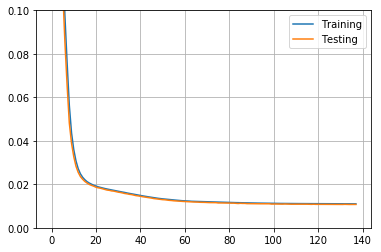

Epoch 138: training loss: 0.011013569310307503, testing loss:0.01074787974357605
Time: 634.1535243988037s


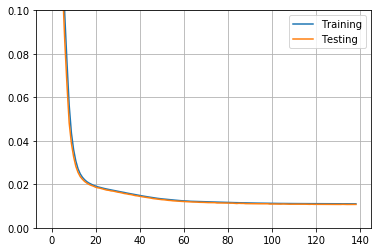

Epoch 139: training loss: 0.01102038100361824, testing loss:0.010753883980214596
Time: 635.9993162155151s


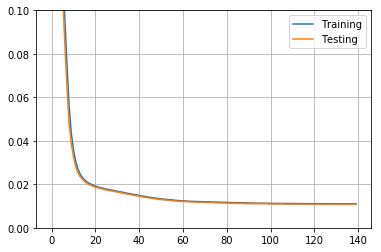

Epoch 140: training loss: 0.011012999340891838, testing loss:0.01070163119584322
Time: 635.7737231254578s


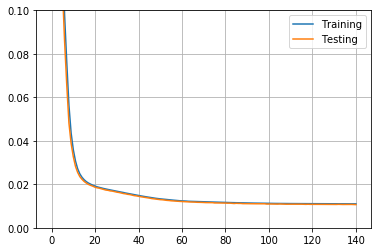

Epoch 141: training loss: 0.011008166708052158, testing loss:0.010660014115273952
Time: 637.0626885890961s


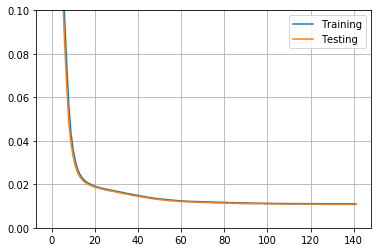

Epoch 142: training loss: 0.011013547889888287, testing loss:0.010750903747975826
Time: 637.4992723464966s


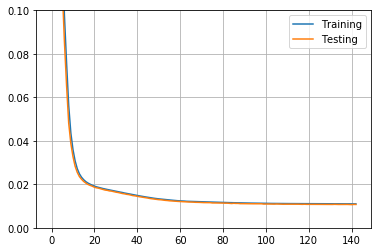

Epoch 143: training loss: 0.011000464670360088, testing loss:0.010737883858382702
Time: 636.7902474403381s


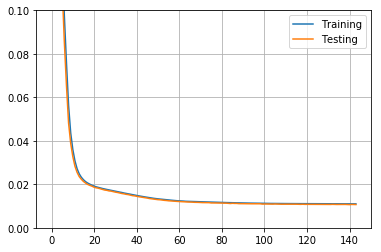

Epoch 144: training loss: 0.011003628373146057, testing loss:0.010691875591874123
Time: 636.3069348335266s


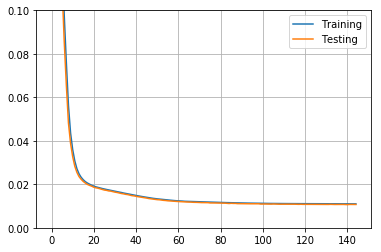

Epoch 145: training loss: 0.011004806496202946, testing loss:0.010728239081799984
Time: 637.6097147464752s


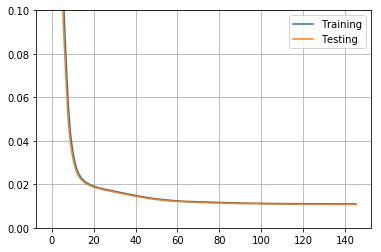

Epoch 146: training loss: 0.010993370786309242, testing loss:0.01061737909913063
Time: 636.2994575500488s


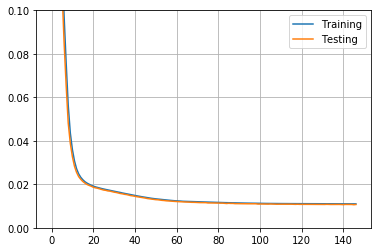

Epoch 147: training loss: 0.01100061647593975, testing loss:0.010722548700869083
Time: 636.7422201633453s


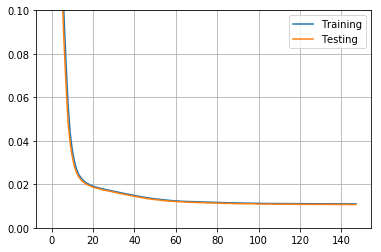

Epoch 148: training loss: 0.010995444841682911, testing loss:0.010712390765547752
Time: 637.4070053100586s


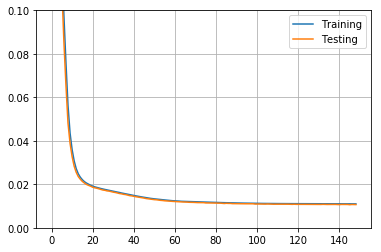

Epoch 149: training loss: 0.011001333594322205, testing loss:0.010678764432668686
Time: 636.5560331344604s


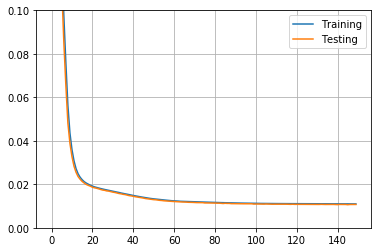

Epoch 150: training loss: 0.010984756983816624, testing loss:0.010734181851148605
Time: 636.5044295787811s


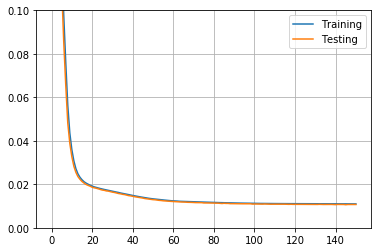

Epoch 151: training loss: 0.010990066453814507, testing loss:0.010720161721110344
Time: 638.0658857822418s


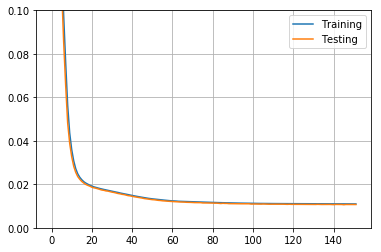

Epoch 152: training loss: 0.010972926393151283, testing loss:0.010709542781114578
Time: 635.963888168335s


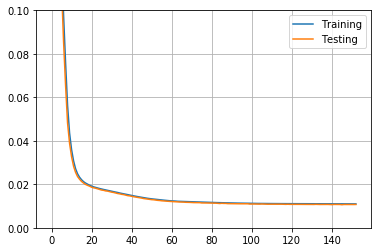

Epoch 153: training loss: 0.010991565883159637, testing loss:0.010733961127698421
Time: 637.7088782787323s


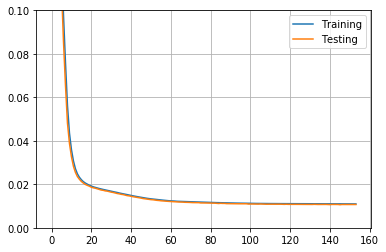

Epoch 154: training loss: 0.010977638885378838, testing loss:0.010715440846979618
Time: 635.9610040187836s


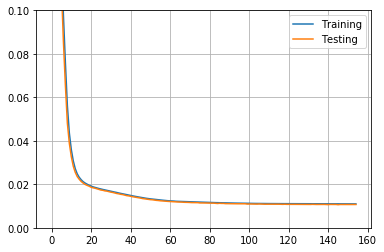

Epoch 155: training loss: 0.010992158204317093, testing loss:0.010722488164901733
Time: 635.0924017429352s


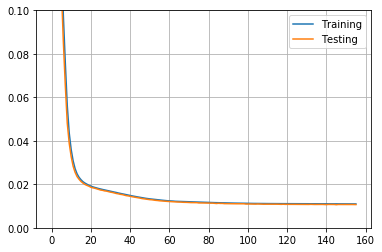

Epoch 156: training loss: 0.01097762119024992, testing loss:0.01068058330565691
Time: 637.4865121841431s


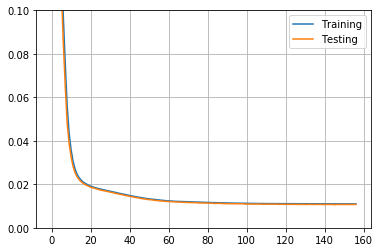

Epoch 157: training loss: 0.010983622632920742, testing loss:0.010736076161265373
Time: 636.8021233081818s


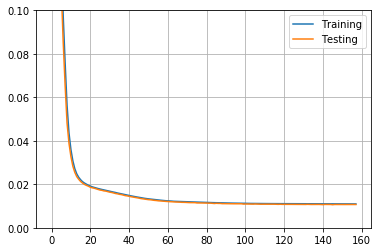

Epoch 158: training loss: 0.010975608602166176, testing loss:0.01071636937558651
Time: 636.1676959991455s


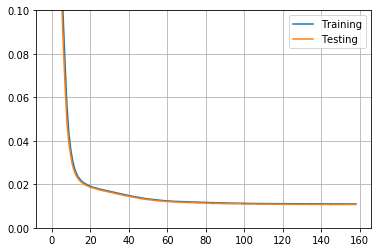

Epoch 159: training loss: 0.010973461903631687, testing loss:0.010713852010667324
Time: 636.187656879425s


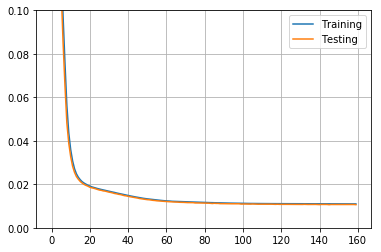

Epoch 160: training loss: 0.01098520029336214, testing loss:0.010628269985318184
Time: 635.3965644836426s


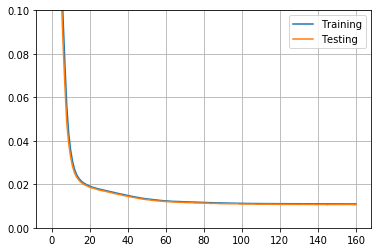

Epoch 161: training loss: 0.010982530191540718, testing loss:0.0106588089838624
Time: 636.8614132404327s


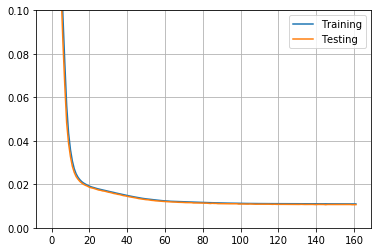

Epoch 162: training loss: 0.010975314304232597, testing loss:0.010652866214513779
Time: 635.1583333015442s


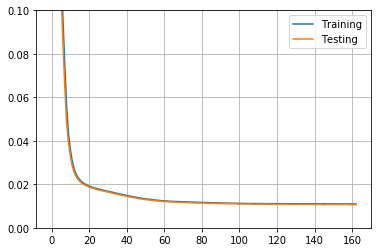

Epoch 163: training loss: 0.010974983684718609, testing loss:0.010664135217666626
Time: 636.0521109104156s


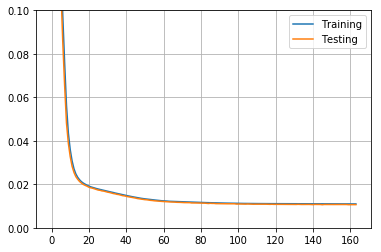

Epoch 164: training loss: 0.010979179292917252, testing loss:0.010653170756995678
Time: 635.7120931148529s


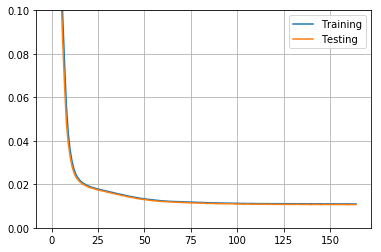

Epoch 165: training loss: 0.010969128459692001, testing loss:0.01068816613405943
Time: 636.3289847373962s


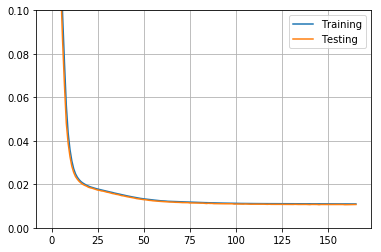

Epoch 166: training loss: 0.01097712479531765, testing loss:0.010723513551056385
Time: 636.2979564666748s


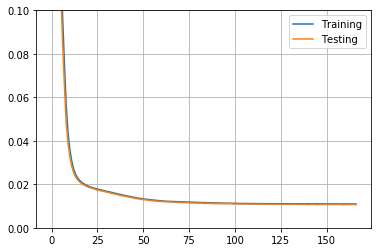

Epoch 167: training loss: 0.010982123203575611, testing loss:0.010628382675349712
Time: 636.3876948356628s


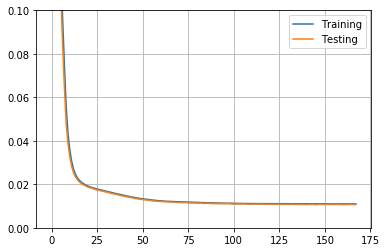

Epoch 168: training loss: 0.010981705971062183, testing loss:0.010750223882496357
Time: 635.4721908569336s


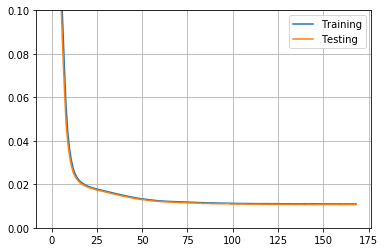

Epoch 169: training loss: 0.010978729464113712, testing loss:0.010656117461621761
Time: 637.6830010414124s


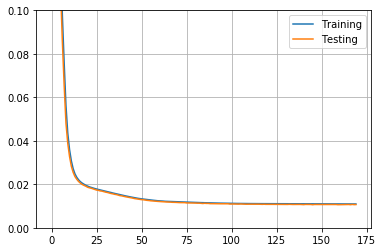

Epoch 170: training loss: 0.010960682295262814, testing loss:0.01069098524749279
Time: 635.6350960731506s


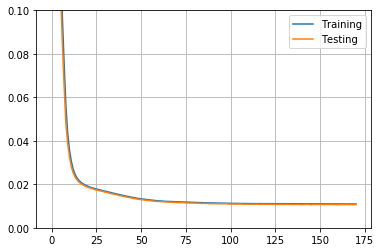

Epoch 171: training loss: 0.01095857098698616, testing loss:0.01069880835711956
Time: 635.7327797412872s


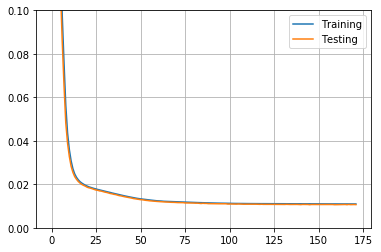

Epoch 172: training loss: 0.01096308697015047, testing loss:0.010665315203368664
Time: 636.1884288787842s


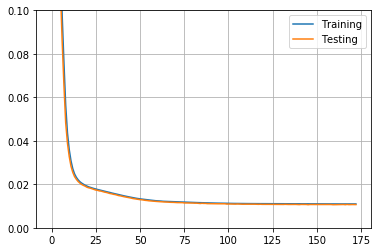

Epoch 173: training loss: 0.010971582494676113, testing loss:0.010678458958864212
Time: 635.388284444809s


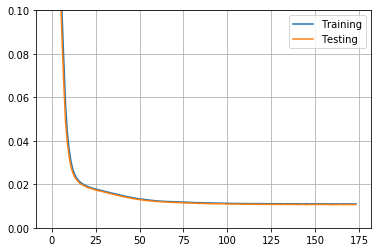

Epoch 174: training loss: 0.010973169468343258, testing loss:0.01071458961814642
Time: 635.8963141441345s


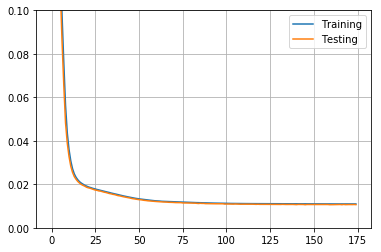

Epoch 175: training loss: 0.010972142219543457, testing loss:0.010651438497006893
Time: 635.526515007019s


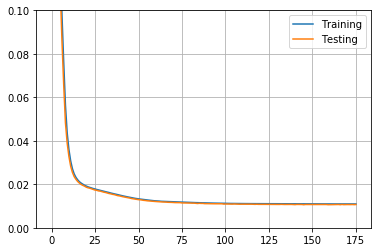

Epoch 176: training loss: 0.010960495099425316, testing loss:0.010704477317631245
Time: 635.7546679973602s


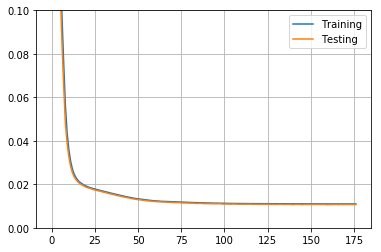

Epoch 177: training loss: 0.010961208492517471, testing loss:0.010695653967559338
Time: 635.2346992492676s


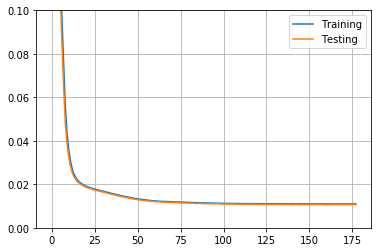

Epoch 178: training loss: 0.010966905392706394, testing loss:0.010662542656064034
Time: 634.1872038841248s


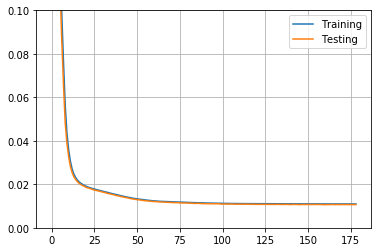

Epoch 179: training loss: 0.010954893194139004, testing loss:0.010647808201611042
Time: 634.7060546875s


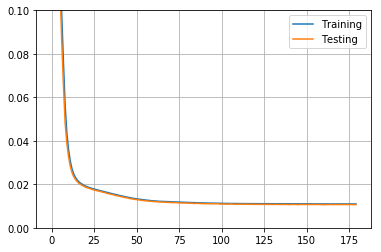

Epoch 180: training loss: 0.010964344255626202, testing loss:0.01065668836236
Time: 634.8739037513733s


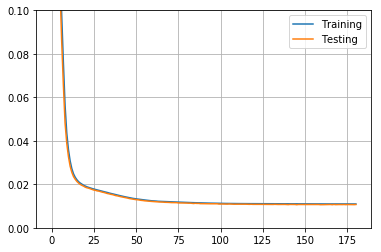

Epoch 181: training loss: 0.010959118604660034, testing loss:0.010720254853367805
Time: 636.6777055263519s


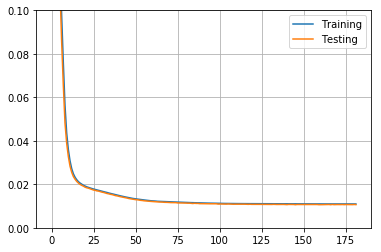

Epoch 182: training loss: 0.01096320990473032, testing loss:0.010657677426934242
Time: 636.0026953220367s


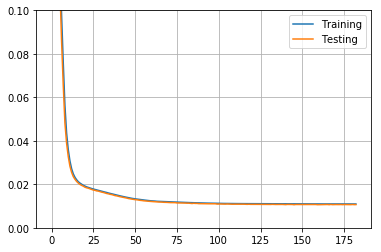

Epoch 183: training loss: 0.010954768396914005, testing loss:0.010676726698875427
Time: 635.6602730751038s


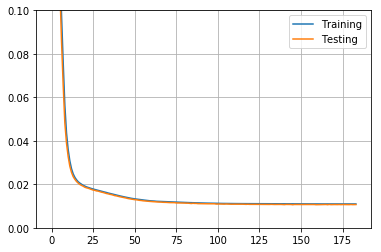

Epoch 184: training loss: 0.010967805981636047, testing loss:0.010695221833884716
Time: 636.5522603988647s


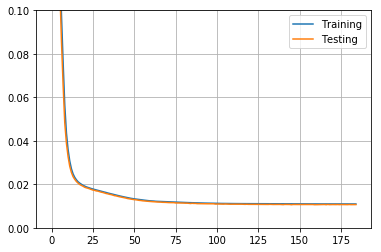

Epoch 185: training loss: 0.010958787053823471, testing loss:0.010683129541575909
Time: 636.5208220481873s


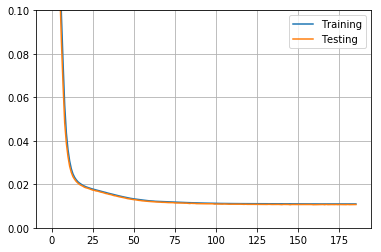

Epoch 186: training loss: 0.010973203927278519, testing loss:0.010706286877393723
Time: 635.8501360416412s


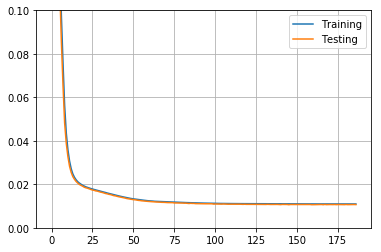

Epoch 187: training loss: 0.010963083244860172, testing loss:0.010673546232283115
Time: 635.9667103290558s


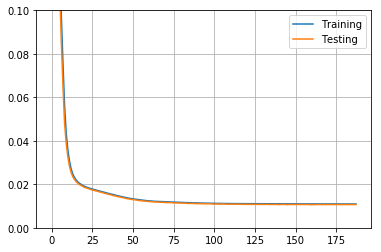

Epoch 188: training loss: 0.01095068920403719, testing loss:0.01068189088255167
Time: 635.736026763916s


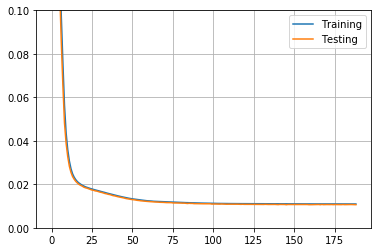

Epoch 189: training loss: 0.01095458585768938, testing loss:0.010631554760038853
Time: 637.2973239421844s


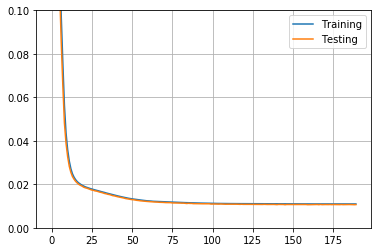

Epoch 190: training loss: 0.010969167575240135, testing loss:0.010671654716134071
Time: 637.2788436412811s


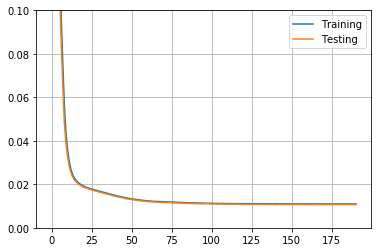

Epoch 191: training loss: 0.010963994078338146, testing loss:0.010632614605128765
Time: 637.6300539970398s


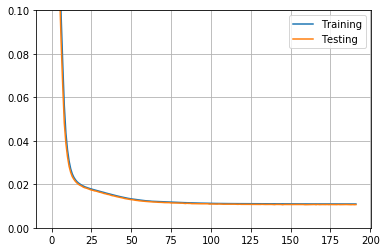

Epoch 192: training loss: 0.010952869430184364, testing loss:0.010677173733711243
Time: 636.4168004989624s


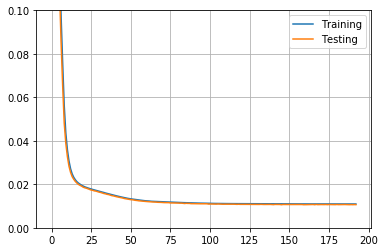

Epoch 193: training loss: 0.010952944867312908, testing loss:0.010648747906088829
Time: 636.4629218578339s


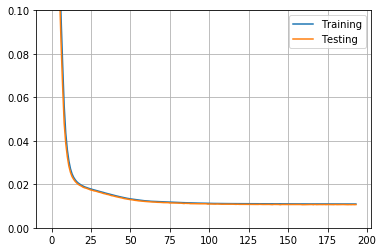

Epoch 194: training loss: 0.010940936394035816, testing loss:0.010683219879865646
Time: 635.370888710022s


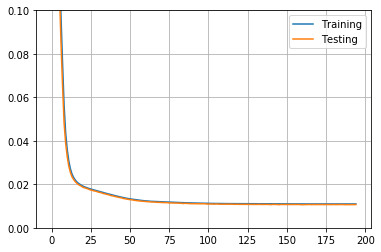

Epoch 195: training loss: 0.010961826890707016, testing loss:0.010694587603211403
Time: 635.928279876709s


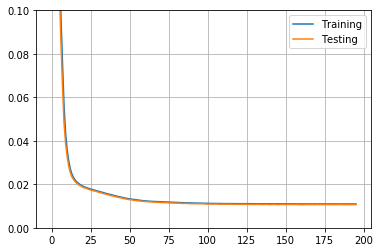

Epoch 196: training loss: 0.010961086489260197, testing loss:0.010663392022252083
Time: 636.0432150363922s


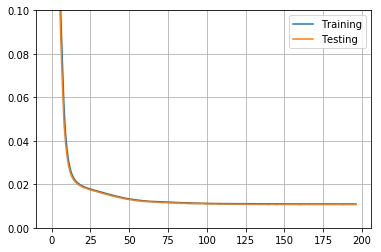

Epoch 197: training loss: 0.0109507841989398, testing loss:0.010694165714085102
Time: 636.2845108509064s


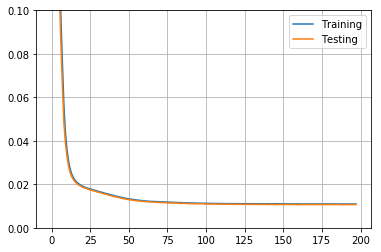

Epoch 198: training loss: 0.01094794925302267, testing loss:0.01065707765519619
Time: 637.3601925373077s


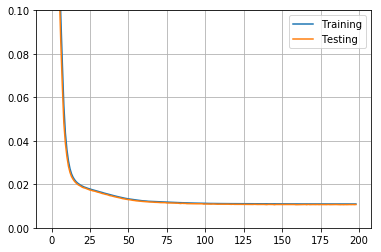

Epoch 199: training loss: 0.010954679921269417, testing loss:0.010707528330385685
Time: 634.8533113002777s


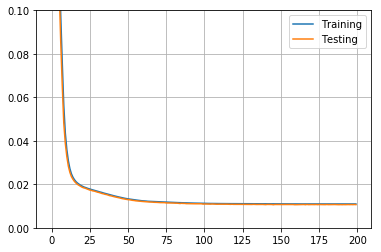

Epoch 200: training loss: 0.010967173613607883, testing loss:0.010656741447746754
Time: 635.8377487659454s


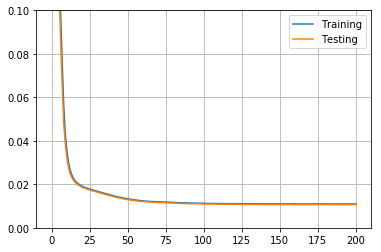

Epoch 201: training loss: 0.010963577777147293, testing loss:0.010631933808326721
Time: 635.1918704509735s


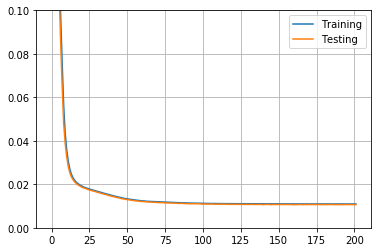

Epoch 202: training loss: 0.010957051068544388, testing loss:0.010679549537599087
Time: 636.976824760437s


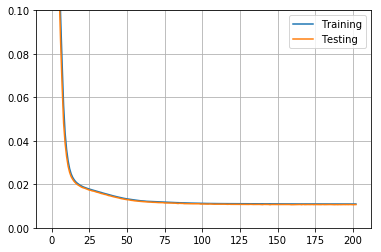

Epoch 203: training loss: 0.010945401154458523, testing loss:0.010683211497962475
Time: 636.1636674404144s


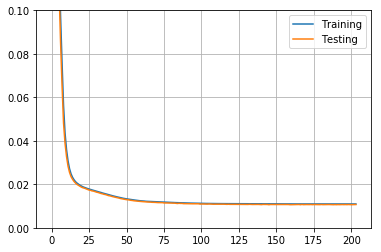

Epoch 204: training loss: 0.010965945199131966, testing loss:0.010702724568545818
Time: 635.3240218162537s


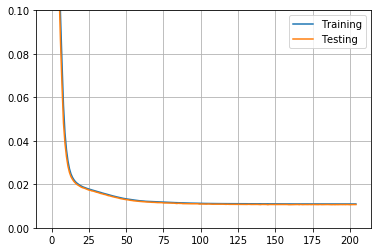

Epoch 205: training loss: 0.010958511382341385, testing loss:0.010690852999687195
Time: 635.9135024547577s


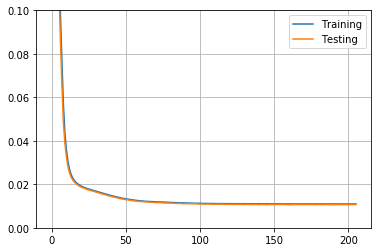

Epoch 206: training loss: 0.010958834551274776, testing loss:0.0106819374486804
Time: 636.2071344852448s


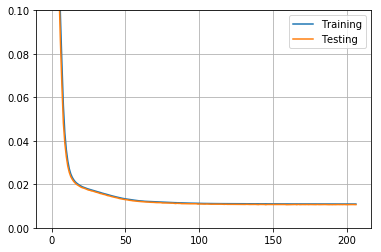

Epoch 207: training loss: 0.010935687460005283, testing loss:0.010661249980330467
Time: 635.2072758674622s


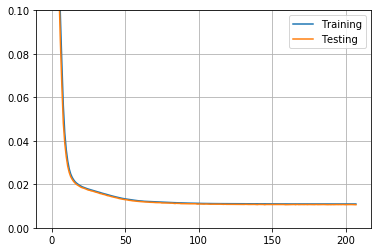

Epoch 208: training loss: 0.010958455502986908, testing loss:0.010618985630571842
Time: 635.6900808811188s


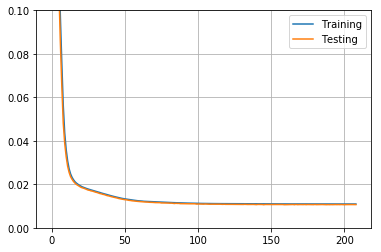

Epoch 209: training loss: 0.010941854678094387, testing loss:0.01067435834556818
Time: 636.5664706230164s


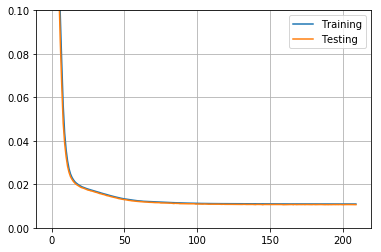

Epoch 210: training loss: 0.010940036736428738, testing loss:0.010652520693838596
Time: 635.4667010307312s


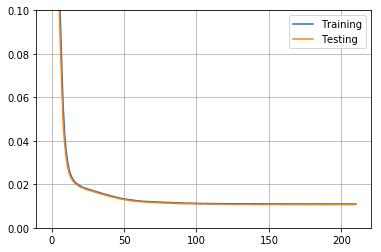

Epoch 211: training loss: 0.010953370481729507, testing loss:0.01070111058652401
Time: 635.2308106422424s


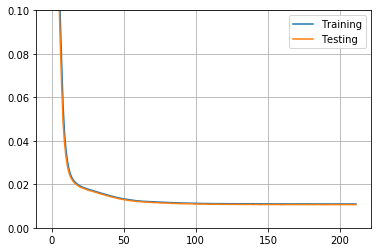

Epoch 212: training loss: 0.010964185930788517, testing loss:0.010652684606611729
Time: 635.7036204338074s


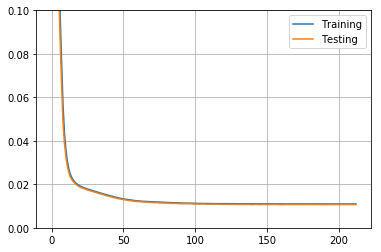

Epoch 213: training loss: 0.010949227958917618, testing loss:0.010636945255100727
Time: 636.3323953151703s


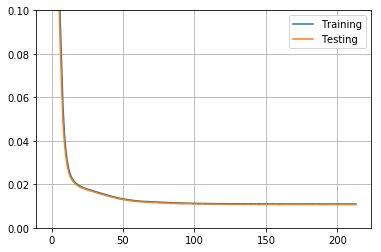

Epoch 214: training loss: 0.010956170037388802, testing loss:0.010644963942468166
Time: 636.9176380634308s


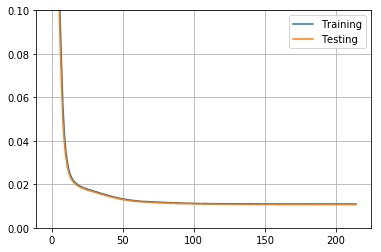

Epoch 215: training loss: 0.010948670096695423, testing loss:0.01061534695327282
Time: 634.5340261459351s


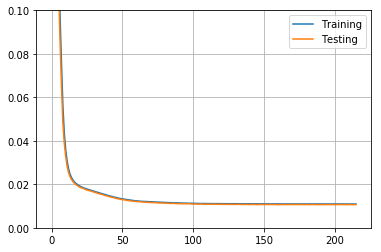

Epoch 216: training loss: 0.010941429995000362, testing loss:0.010666669346392155
Time: 636.3130218982697s


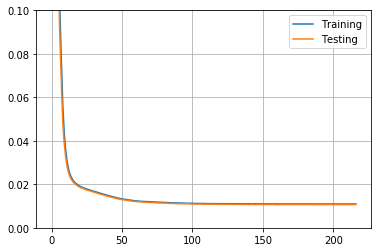

Epoch 217: training loss: 0.0109517527744174, testing loss:0.010696928016841412
Time: 636.0067417621613s


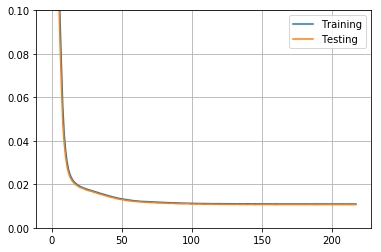

Epoch 218: training loss: 0.010954126715660095, testing loss:0.010669645853340626
Time: 635.8474321365356s


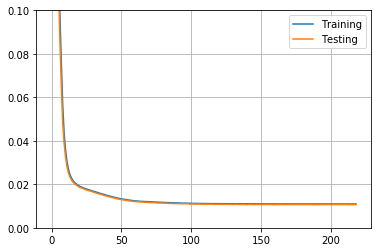

Epoch 219: training loss: 0.010946180671453476, testing loss:0.01067079696804285
Time: 636.3181862831116s


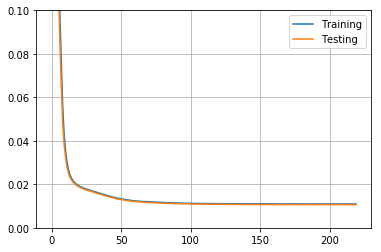

Epoch 220: training loss: 0.010958719067275524, testing loss:0.010616996325552464
Time: 636.6882379055023s


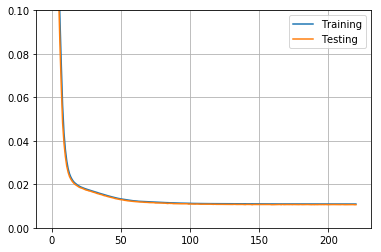

Epoch 221: training loss: 0.010938967578113079, testing loss:0.010626099072396755
Time: 635.2470190525055s


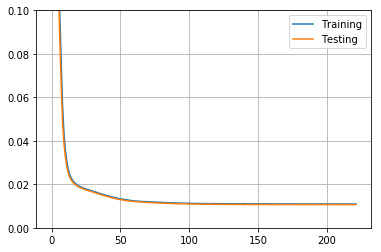

Epoch 222: training loss: 0.010935609228909016, testing loss:0.010666094720363617
Time: 636.0703146457672s


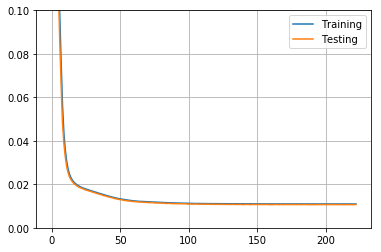

Epoch 223: training loss: 0.010957174003124237, testing loss:0.010695289820432663
Time: 637.771810054779s


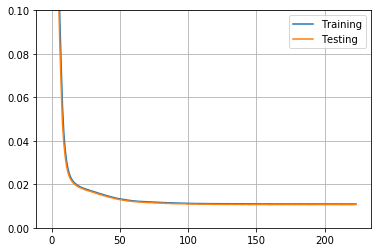

Epoch 224: training loss: 0.010945224203169346, testing loss:0.010722422040998936
Time: 637.084272146225s


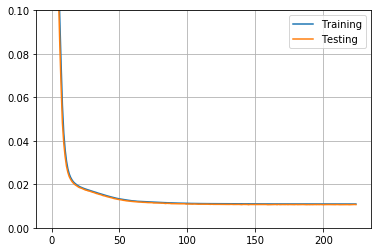

Epoch 225: training loss: 0.010947510600090027, testing loss:0.01067779678851366
Time: 637.6340353488922s


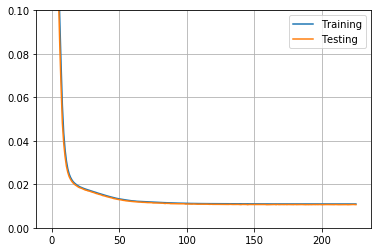

Epoch 226: training loss: 0.010956204496324062, testing loss:0.010658591985702515
Time: 636.7900342941284s


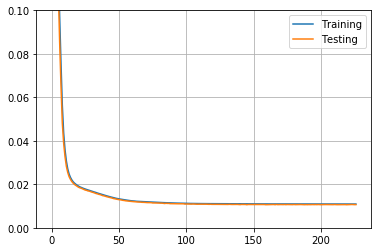

Epoch 227: training loss: 0.010930742137134075, testing loss:0.010663888417184353
Time: 636.9413802623749s


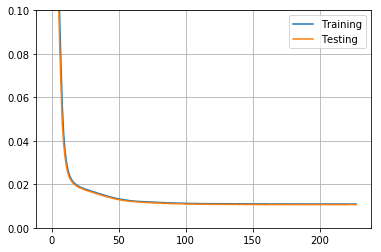

Epoch 228: training loss: 0.010972026735544205, testing loss:0.01062577310949564
Time: 636.1312348842621s


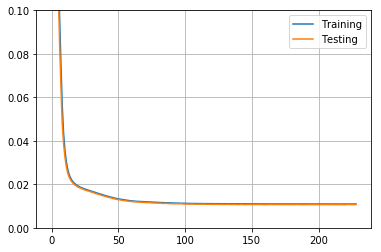

Epoch 229: training loss: 0.010939853265881538, testing loss:0.01069494429975748
Time: 635.3484265804291s


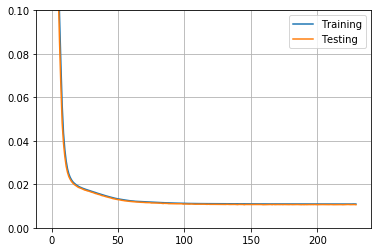

Epoch 230: training loss: 0.010939325205981731, testing loss:0.010622384957969189
Time: 637.2719080448151s


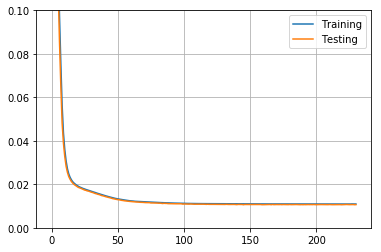

Epoch 231: training loss: 0.010951386764645576, testing loss:0.010658358223736286
Time: 634.8840038776398s


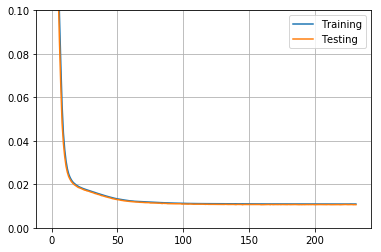

Epoch 232: training loss: 0.010947360657155514, testing loss:0.010637065395712852
Time: 635.6851246356964s


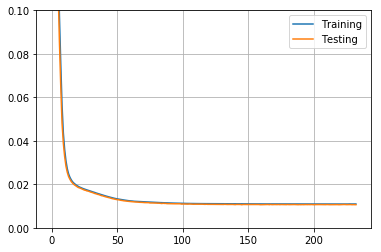

Epoch 233: training loss: 0.010958672501146793, testing loss:0.010629802942276001
Time: 636.4567401409149s


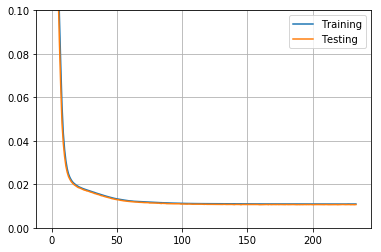

Epoch 234: training loss: 0.010950946249067783, testing loss:0.010693829506635666
Time: 637.1263828277588s


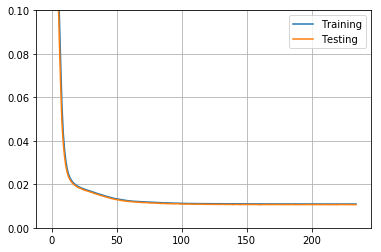

Epoch 235: training loss: 0.010957726277410984, testing loss:0.010619038715958595
Time: 634.1434564590454s


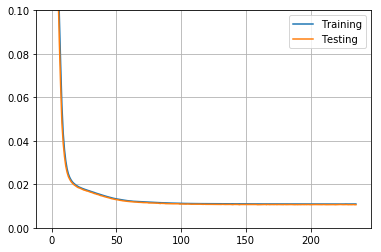

Epoch 236: training loss: 0.0109553886577487, testing loss:0.010624086484313011
Time: 634.81795835495s


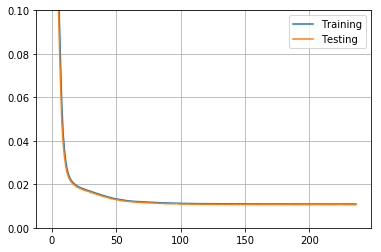

Epoch 237: training loss: 0.010939739644527435, testing loss:0.01065368577837944
Time: 633.9540612697601s


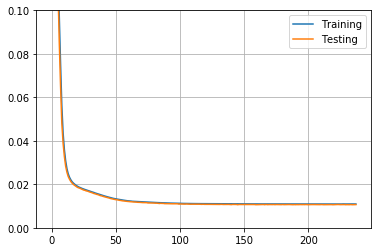

Epoch 238: training loss: 0.010943987406790257, testing loss:0.010673903860151768
Time: 635.7457416057587s


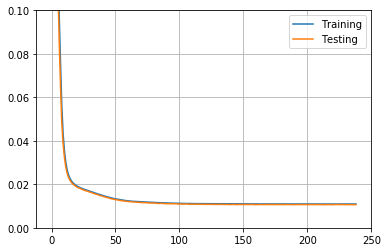

Epoch 239: training loss: 0.01094882097095251, testing loss:0.010657839477062225
Time: 636.5999264717102s


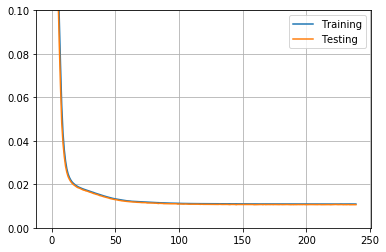

Epoch 240: training loss: 0.010935453698039055, testing loss:0.010639967396855354
Time: 636.0288410186768s


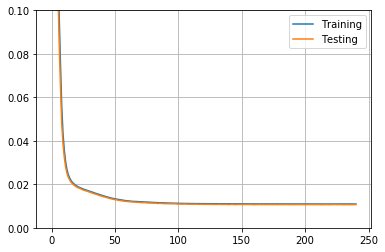

Epoch 241: training loss: 0.0109311044216156, testing loss:0.0106737045571208
Time: 635.0309181213379s


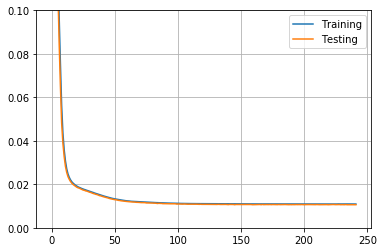

Epoch 242: training loss: 0.010931110009551048, testing loss:0.010620790533721447
Time: 634.9926528930664s


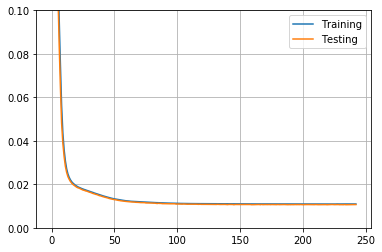

Epoch 243: training loss: 0.010947789996862411, testing loss:0.010691959410905838
Time: 635.5893199443817s


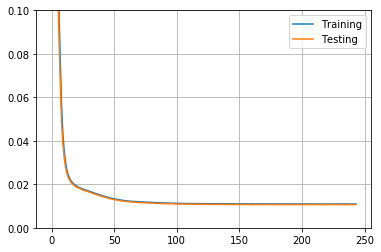

Epoch 244: training loss: 0.01094250101596117, testing loss:0.01068489346653223
Time: 636.4515058994293s


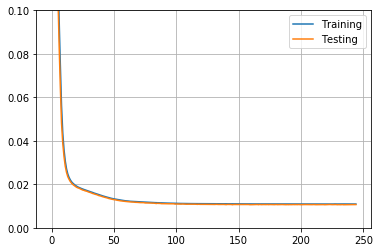

Epoch 245: training loss: 0.010931776836514473, testing loss:0.010688221082091331
Time: 635.512627363205s


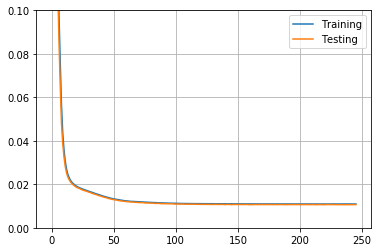

Epoch 246: training loss: 0.010946669615805149, testing loss:0.010667776688933372
Time: 635.8744623661041s


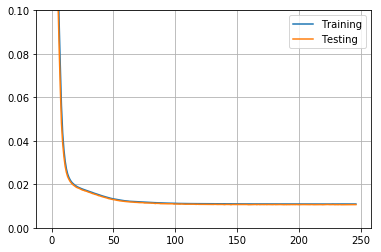

Epoch 247: training loss: 0.010943482629954815, testing loss:0.010669935494661331
Time: 636.3538882732391s


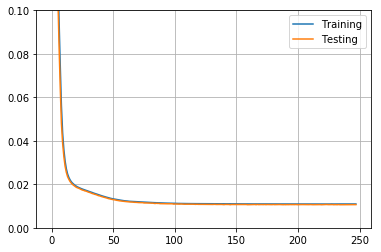

Epoch 248: training loss: 0.010957088321447372, testing loss:0.010663839988410473
Time: 635.4711346626282s


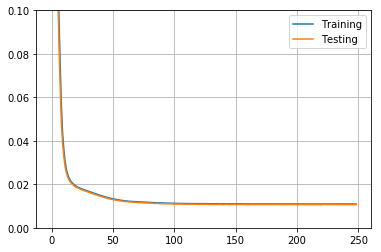

Epoch 249: training loss: 0.010934288613498211, testing loss:0.010630876757204533
Time: 636.2115578651428s


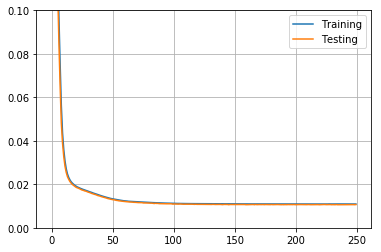

Epoch 250: training loss: 0.010936922393739223, testing loss:0.010685321874916553
Time: 633.3654153347015s


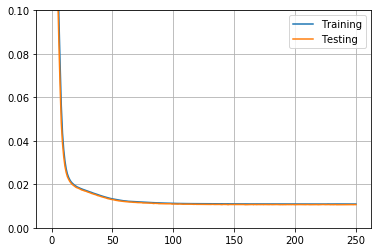

Epoch 251: training loss: 0.010931586846709251, testing loss:0.010651692748069763
Time: 633.6752331256866s


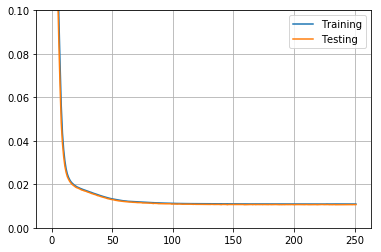

Epoch 252: training loss: 0.010933822020888329, testing loss:0.010682444088160992
Time: 635.4462103843689s


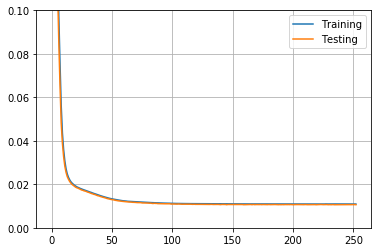

Epoch 253: training loss: 0.01093027088791132, testing loss:0.01061349269002676
Time: 635.7435722351074s


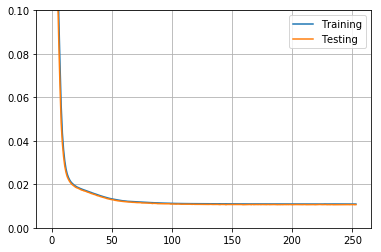

Epoch 254: training loss: 0.010925729759037495, testing loss:0.010655304417014122
Time: 635.3758356571198s


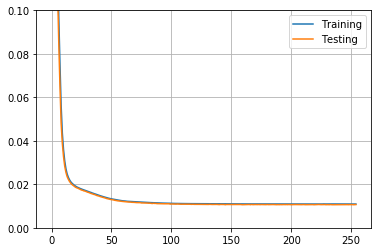

Epoch 255: training loss: 0.010930892080068588, testing loss:0.010686016641557217
Time: 635.5733716487885s


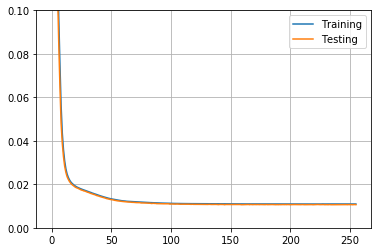

Epoch 256: training loss: 0.010946670547127724, testing loss:0.010634288191795349
Time: 634.8715851306915s


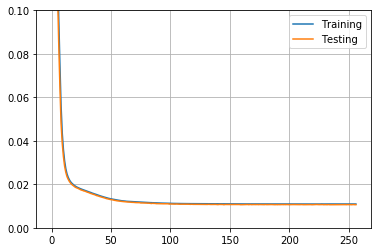

Epoch 257: training loss: 0.01094497088342905, testing loss:0.010635431855916977
Time: 636.579247713089s


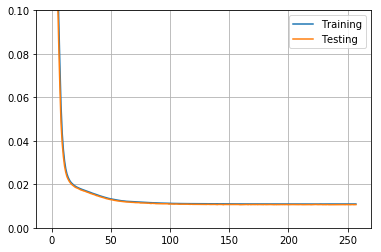

Epoch 258: training loss: 0.010952855460345745, testing loss:0.0106715839356184
Time: 634.4428527355194s


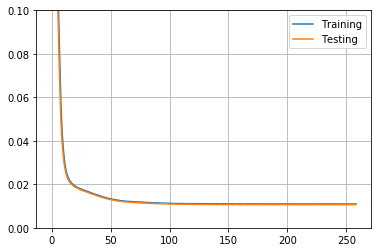

Epoch 259: training loss: 0.010937065817415714, testing loss:0.010657605715095997
Time: 635.4767677783966s


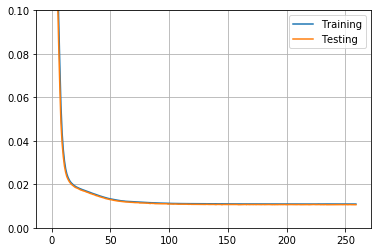

Epoch 260: training loss: 0.010928892530500889, testing loss:0.010624246671795845
Time: 635.8788504600525s


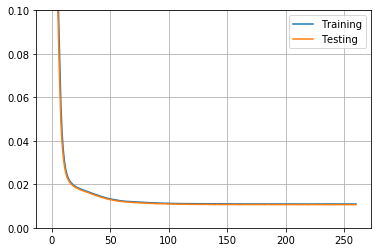

Epoch 261: training loss: 0.010940582491457462, testing loss:0.010645329020917416
Time: 640.5917401313782s


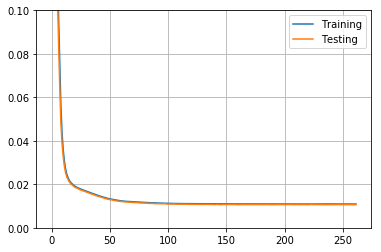

Epoch 262: training loss: 0.010932122357189655, testing loss:0.01064453087747097
Time: 661.0880451202393s


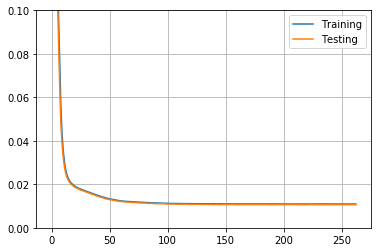

Epoch 263: training loss: 0.010922199115157127, testing loss:0.010655384510755539
Time: 650.5750033855438s


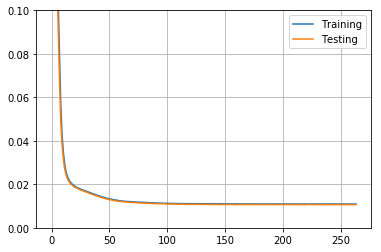

Epoch 264: training loss: 0.010930990800261497, testing loss:0.010650791227817535
Time: 636.223801612854s


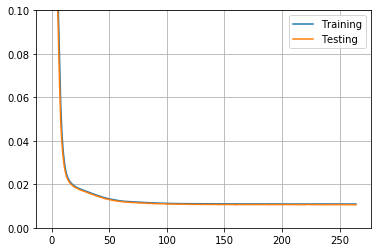

Epoch 265: training loss: 0.010946487076580524, testing loss:0.01060236245393753
Time: 634.8528010845184s


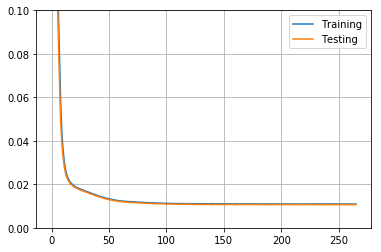

Epoch 266: training loss: 0.010929636657238007, testing loss:0.010629717260599136
Time: 636.3230402469635s


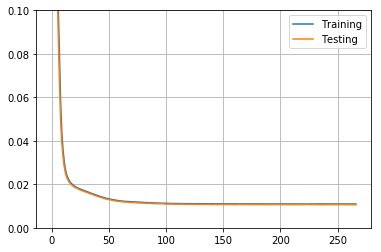

Epoch 267: training loss: 0.010936759412288666, testing loss:0.010618909262120724
Time: 636.541250705719s


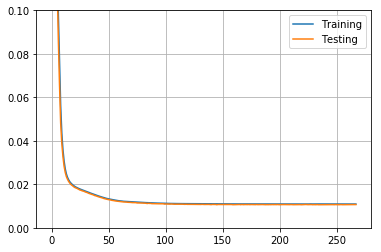

Epoch 268: training loss: 0.010924667119979858, testing loss:0.01068680640310049
Time: 636.8085658550262s


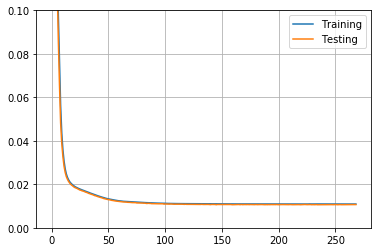

Epoch 269: training loss: 0.01093257311731577, testing loss:0.010686654597520828
Time: 636.2017273902893s


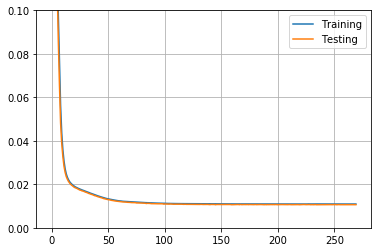

Epoch 270: training loss: 0.010937896557152271, testing loss:0.010636021383106709
Time: 637.1347134113312s


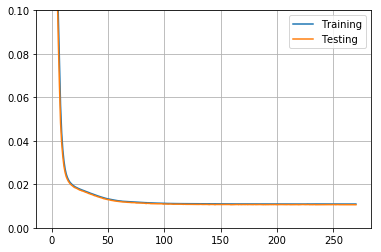

Epoch 271: training loss: 0.01094141136854887, testing loss:0.010613473132252693
Time: 635.4417343139648s


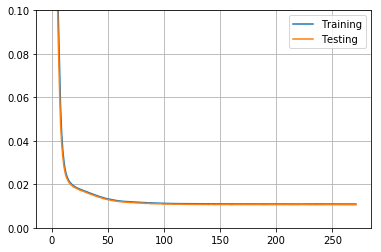

Epoch 272: training loss: 0.01092638447880745, testing loss:0.010611099191009998
Time: 634.879065990448s


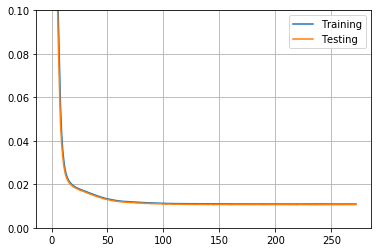

Epoch 273: training loss: 0.010915521532297134, testing loss:0.010682721622288227
Time: 636.7620396614075s


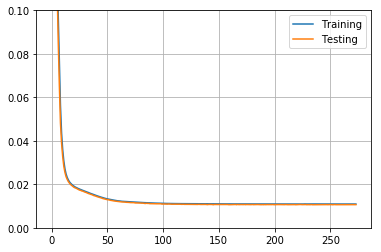

Epoch 274: training loss: 0.010928498581051826, testing loss:0.010652814991772175
Time: 635.9782168865204s


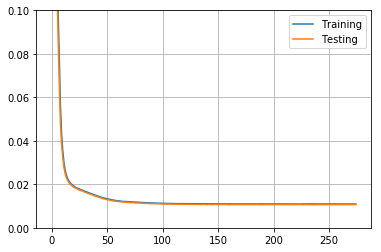

Epoch 275: training loss: 0.010919253341853619, testing loss:0.010661034844815731
Time: 636.0035648345947s


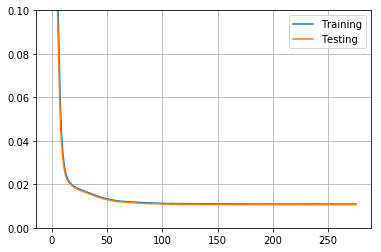

Epoch 276: training loss: 0.010926264338195324, testing loss:0.010624011978507042
Time: 636.3184685707092s


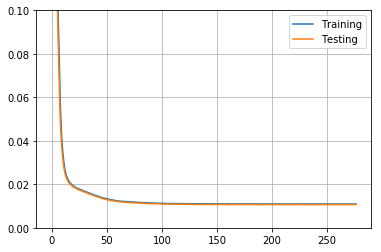

Epoch 277: training loss: 0.010923407971858978, testing loss:0.010663183405995369
Time: 635.4860081672668s


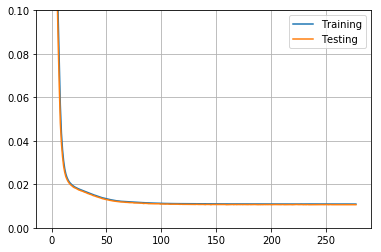

Epoch 278: training loss: 0.010917446576058865, testing loss:0.010626132600009441
Time: 635.3390345573425s


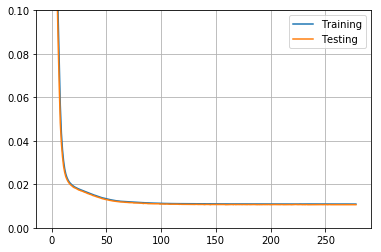

Epoch 279: training loss: 0.010918415151536465, testing loss:0.01063019223511219
Time: 635.4766457080841s


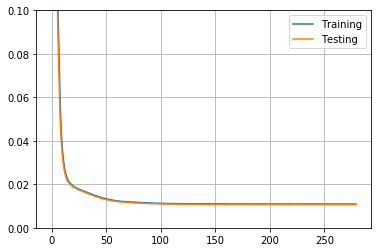

Epoch 280: training loss: 0.010913056321442127, testing loss:0.010611011646687984
Time: 635.7633280754089s


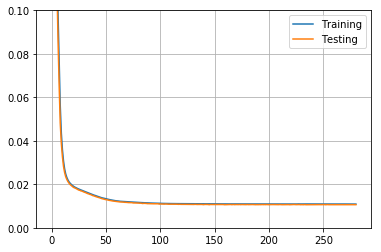

Epoch 281: training loss: 0.010907648131251335, testing loss:0.01063732523471117
Time: 634.1181223392487s


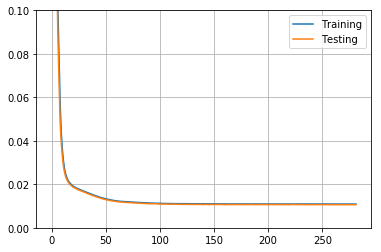

Epoch 282: training loss: 0.010923574678599834, testing loss:0.010621117427945137
Time: 637.1693685054779s


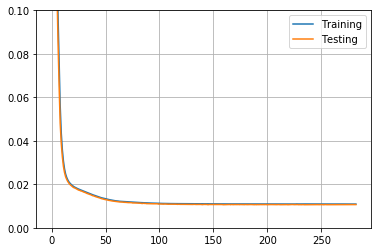

Epoch 283: training loss: 0.010914649814367294, testing loss:0.010679089464247227
Time: 634.0527222156525s


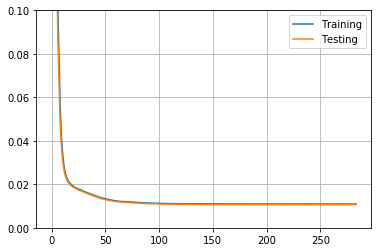

Epoch 284: training loss: 0.010929207317531109, testing loss:0.010634844191372395
Time: 637.242490530014s


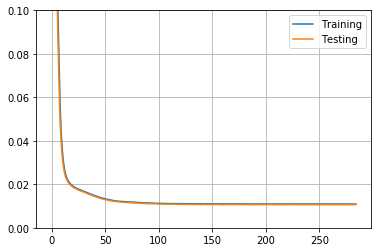

Epoch 285: training loss: 0.010915668681263924, testing loss:0.010630461387336254
Time: 635.5026450157166s


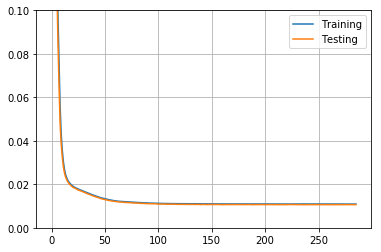

Epoch 286: training loss: 0.010921991430222988, testing loss:0.01065122988075018
Time: 636.4609227180481s


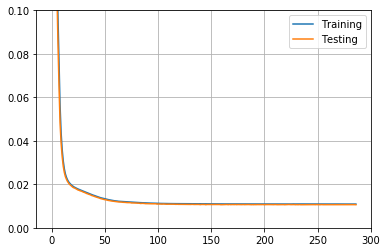

Epoch 287: training loss: 0.01092170923948288, testing loss:0.01061633974313736
Time: 635.186812877655s


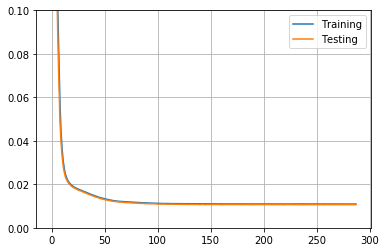

Epoch 288: training loss: 0.010927587747573853, testing loss:0.010646731592714787
Time: 635.260303735733s


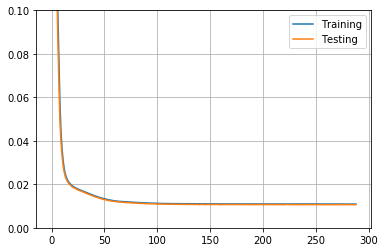

Epoch 289: training loss: 0.010906948707997799, testing loss:0.01066160574555397
Time: 637.0911402702332s


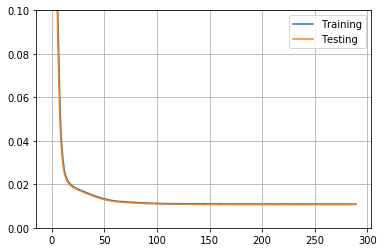

Epoch 290: training loss: 0.010909545235335827, testing loss:0.010666394606232643
Time: 635.2173783779144s


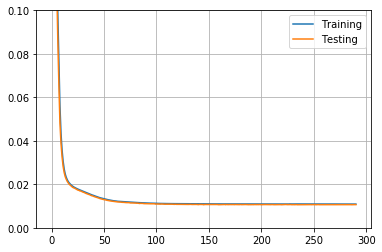

Epoch 291: training loss: 0.010906985960900784, testing loss:0.010651451535522938
Time: 634.6263432502747s


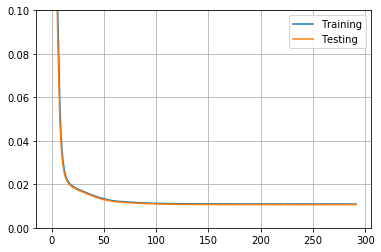

Epoch 292: training loss: 0.01091262511909008, testing loss:0.010659076273441315
Time: 634.80397772789s


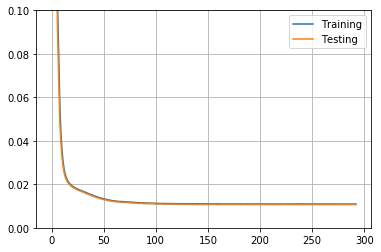

Epoch 293: training loss: 0.010914553888142109, testing loss:0.010633960366249084
Time: 634.210620880127s


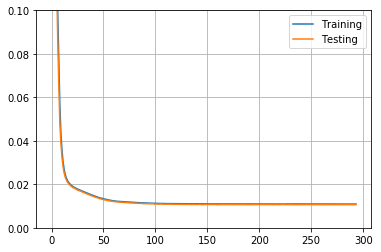

Epoch 294: training loss: 0.010915380902588367, testing loss:0.010643786750733852
Time: 634.5964553356171s


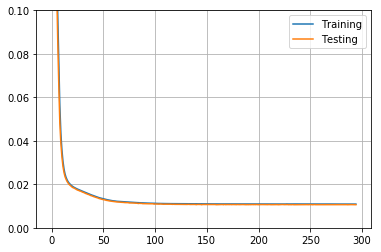

Epoch 295: training loss: 0.01090814545750618, testing loss:0.010626477189362049
Time: 637.2315428256989s


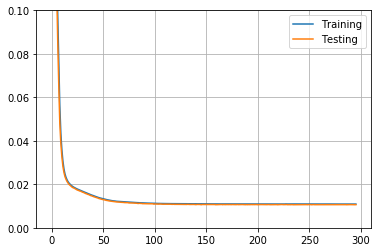

Epoch 296: training loss: 0.010912706144154072, testing loss:0.010639755986630917
Time: 634.7029609680176s


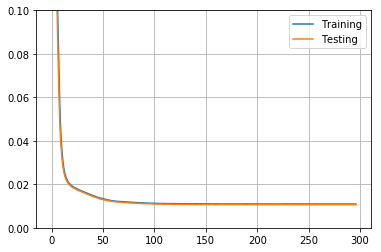

Epoch 297: training loss: 0.010912243276834488, testing loss:0.010642047971487045
Time: 633.3348162174225s


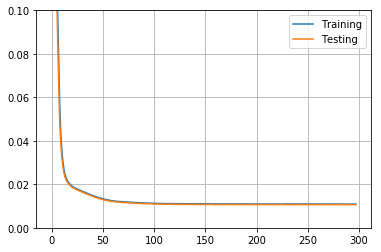

Epoch 298: training loss: 0.010904641821980476, testing loss:0.010575884953141212
Time: 635.6855311393738s


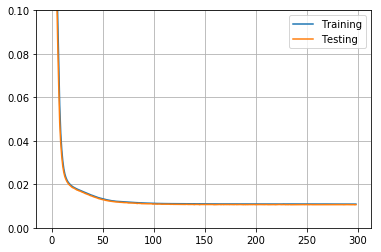

Epoch 299: training loss: 0.010897613130509853, testing loss:0.01064293086528778
Time: 635.2413349151611s


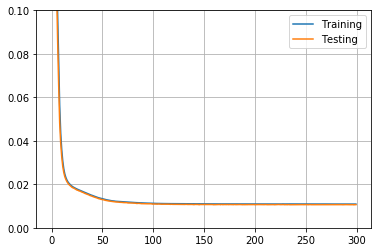

Epoch 300: training loss: 0.0109091866761446, testing loss:0.010643652640283108
Time: 637.6145830154419s


In [5]:
#training
while epoch < num_epoch:
    
    start = time.time()
    
    stats.init()
    for batch in train_loader:
        pc, x, d = batch[0].cuda(), batch[1].cuda(), batch[2].cuda()
        optimizer.zero_grad()
        z = enet(pc)
        y = pnet(z, x)
        loss = pnet.criterion(d, y)
        loss.backward()
        with torch.no_grad():
            stats.accumulate(loss)
        optimizer.step()
    train_loss.append(stats.summarize())
    
    stats.init()
    for batch in val_loader:
        pc, x, d = batch[0].cuda(), batch[1].cuda(), batch[2].cuda()
        z = enet(pc)
        y = pnet(z, x)
        loss = pnet.criterion(d, y)
        with torch.no_grad():
            stats.accumulate(loss)
    test_loss.append(stats.summarize())

    plt.plot(train_loss, label = 'Training')
    plt.plot(test_loss, label = 'Testing')
    plt.grid()
    plt.ylim(0, 0.1)
    plt.legend()
    plt.show()

    torch.save(enet, 'saved_enet.pth')
    torch.save(pnet, 'saved_pnet.pth')
        
    epoch += 1
    
    with open('checkpoint.pkl', 'wb') as f:
        pickle.dump((epoch, train_loss, test_loss, optimizer.state_dict()), f)
    print("Epoch {}: training loss: {}, testing loss:{}\nTime: {}s".format(epoch, train_loss[-1], test_loss[-1], time.time() - start))